In [ ]:
# This allows execution from the docs/ directory
import sys
if '../' not in sys.path:
    sys.path.insert(0, '../')

In [ ]:
import matplotlib.pyplot as pl
pl.rcParams.update({
    "font.family": "serif",
    'font.size': 11.0,
    'axes.labelsize': 'medium',
    'xtick.major.pad': 2.0,
    'ytick.major.pad': 2.0,
    'xtick.major.size': 4.0,
    'ytick.major.size': 4.0,
    'savefig.bbox': 'tight',
    'savefig.dpi': 180,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'legend.frameon': False,
})

```
    index
```

In this tutorial, we\'ll show how to analyze molecular dynamics
trajectories using the `atooms` package and its
`postprocessing` component. You can install
`postprocessing` from pypi:
`pip install atooms-pp`.

## Setup

We start with a few imports. We will read a trajectory file in XYZ
format, so we also load the `TrajectoryXYZ` class from
`atooms`.


In [ ]:
import matplotlib.pyplot as pl
import atooms.postprocessing as pp
from atooms.trajectory import TrajectoryXYZ 

We consider a sample trajectory, which can be downloaded from the
package repository.


In [ ]:
from atooms.core.utils import download
download('https://framagit.org/atooms/postprocessing/raw/master/data/kalj.xyz', "/tmp")
path = '/tmp/kalj.xyz'

### Handling a trajectory

A trajectory is an object with many properties. To load a trajectory, we
create an instance of the class as follows


In [ ]:
th = TrajectoryXYZ(path)

The trajectory is a list-like object, in the sense that it can be
iterated upon and sliced. Each frame of the trajectory contains a
`System` object, which is a snaphot of the system at a given
instant (\"frame\") during the simulation. We have a look at the last
frame


In [ ]:
print(th[-1])

To know how many frames we have


In [ ]:
print(len(th))

```
To clarify: a slice like =th[10: 12]= is a list of frames, not a trajectory. It is possible to define a slice of a trajectory *as a trajectory* instance by using the =Sliced= class decorator, see below.
```

If the trajectory contains metadata, these can be retrieved directly:


In [ ]:
from pprint import pprint
print("Timestep during the trajectory:", th.timestep)
print("Steps after which the 3rd frame was stored:", th.steps[2])
print("Additional metadata:")
pprint(th.metadata)

### Trajectories as numpy arrays

If your trajectory data is stored as a big numpy array already, it is
easy to wrap it in a `TrajectoryRam` object. Let us assume
the particle positions are stored as a $(N_t, N, d)$ shaped numpy array,
where $N_t$ is the number of frames, $N$ is the number of particles and
$d$ is the dimensionality of the system.


In [ ]:
import numpy

N_t, N, d = 10, 100, 3
pos = numpy.ndarray((N_t, N, d))
spe = numpy.ndarray((N_t, N), dtype=int)  # an integer or string label for species
box = numpy.ndarray(d)  # cell side, we assume it is not variable

Then you can load this array into a `TrajectoryRam` object,
which holds everything in memory.


In [ ]:
from atooms.trajectory import TrajectoryRam

with TrajectoryRam() as th:
    for _pos, _spe in zip(pos, spe):
        s = System(N=_pos.shape[0])
        s.cell.side[:] = box
        s.view('species')[:] = _spe
        s.view('position')[:, :] = _pos
        th.append(s)

This way, the trajectory never needs to be written on disk and can be
analyzed on the fly.


```
Note that the =System= instance holds particles' coordinates and species as views of the original numpy arrays. If you change the latter, the =TrajectoryRam= instance will change as well.
```

## Analysis of the trajectory

Now that we have constructed a trajectory object, we can proceed to the
analysis. We will consider a few basic static and dynamic correlation
functions.

### Radial distribution function

The radial distribution function $g(r)$ describes how the local density
varies as a function of the distance from a reference particle. In
liquids, one normally averages over all particles, obtaining a
descriptor of the probability to find a second particle a distance $r$
from a given particle, relative to that of the ideal gas.

For $N$ particles of the same type at density $\rho$ it is

$$g(r)=\frac{1}{N\rho}\left\langle\sum_i^{N}\sum_{i\neq j}\delta(r-|\mathbf{r}_i-\mathbf{r}_j|)\right\rangle$$

Notice that the average number of particles with a distance $R$, i.e.
the average **coordination number** $n(R)$, can be computed from the
radial distribution function via integration in spherical coordinates
(for 3D systems)

$$n(R)=4\pi \rho\int_0^R g(r)r^2 dr$$

In `postprocessing` the radial distribution function is a
`Correlation` object that takes a trajectory as input. In
order to compute the correlation function, we construct the object,
specifying some parameters, and then run the calculation with the
`compute()` method.


In [ ]:
# We let postprocessing choose a reasonable number of time origins for the average
gr = pp.RadialDistributionFunction(th, dr=0.03)
gr.compute()
# We average over all the frames
gr_all = pp.RadialDistributionFunction(th, dr=0.03, norigins=len(th))
gr_all.compute()

Once the calculation is performed, the radial distribution object
`gr` contains (like all correlators in
`postprocessing`) two arrays:

-   the `grid` array contains the independent variable (or
    variables), binned according to our input parameters (in this case,
    the smallest space interval that we resolve, `dr`)
-   the `value` array contains the actual value of the
    computation, in this case the values of $g(r)$

As you can see there is very little improvement when using the full
trajectory.


In [ ]:
pl.plot(gr.grid, gr.value, label='Default')
pl.plot(gr_all.grid, gr_all.value, label='All time origins')
pl.xlabel("$r$")
pl.ylabel("$g(r)$")

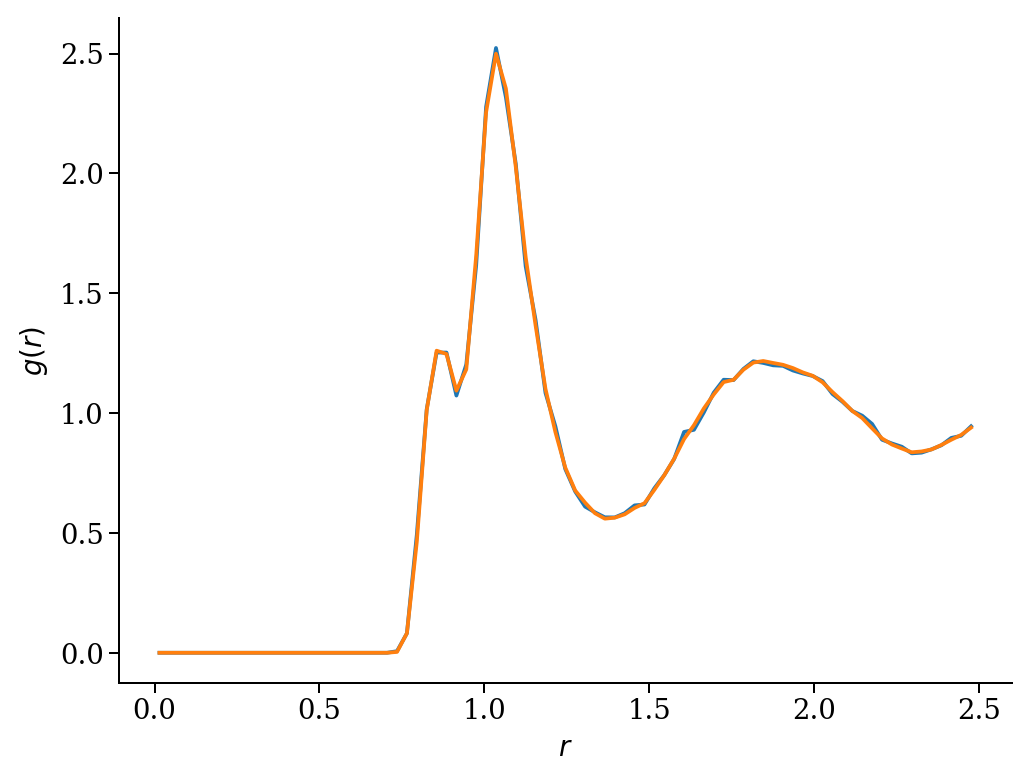

You can show the results right away with the `show()` method,
which formats the labels automatically. The method returns a
`matplotlib` axis object for further customization.


In [ ]:
gr.show()

As we can see, the correlation function displays two narrow peaks around
$r=1$ and a broader peak further away. The presence of several peaks is
due to the fact that the system actually contains two types of
particles, noted $A$ and $B$.

We can compute separate distribution functions for the $A$ and $B$
particles and also the cross distribution funtion for the probability to
find a particle $B$ at distance $r$ from particle $A$ using the
`Partial` class.


In [ ]:
gr = pp.Partial(pp.RadialDistributionFunction, species=['A', 'B'], trajectory=th, dr=0.03, norigins=len(th))
gr.partial[('B', 'B')].dr = 0.06
gr.compute() 

Note how we modified the bin width `dr` for the $B$ - $B$
correlations to compensate for the reduced statistics for the minority
species.

In this case, the result contains a dictionary `gr.partial`


In [ ]:
from pprint import pprint
pprint(gr.partial)

We plot all correlation functions


In [ ]:
for key,g in gr.partial.items():
    pl.plot(g.grid, g.value, label=str("".join(key)))
pl.legend()
pl.xlabel("$r$")
pl.ylabel(r"$g_{\alpha\beta}(r)$")

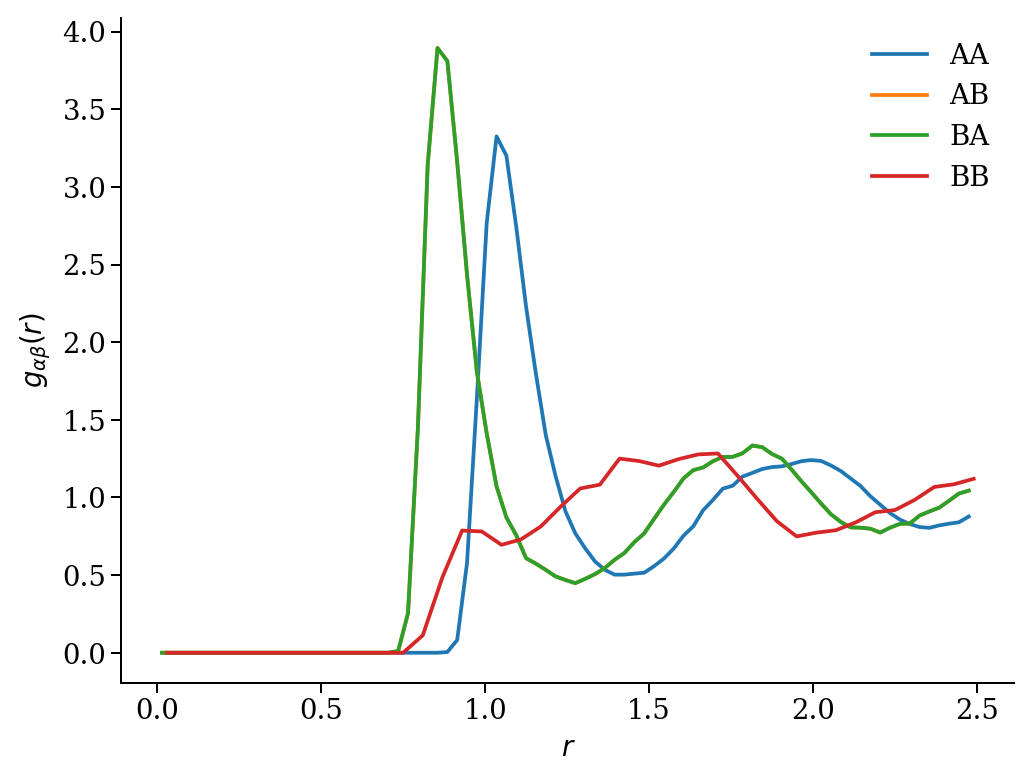

Sometimes, it is useful to analyse only sections of a trajectory. To
this purpose, one can slice the trajectory using `atooms` and
analyse individual frames or subsets of frames.


In [ ]:
from atooms import trajectory
t =  trajectory.Sliced(th, slice(len(th)//2, len(th)))  # analyse only the 2nd half
gr = pp.RadialDistributionFunction(t, dr=0.03)
gr.compute()
pl.plot(gr.grid, gr.value)
pl.xlabel("$r$")
pl.ylabel("$g(r)$")

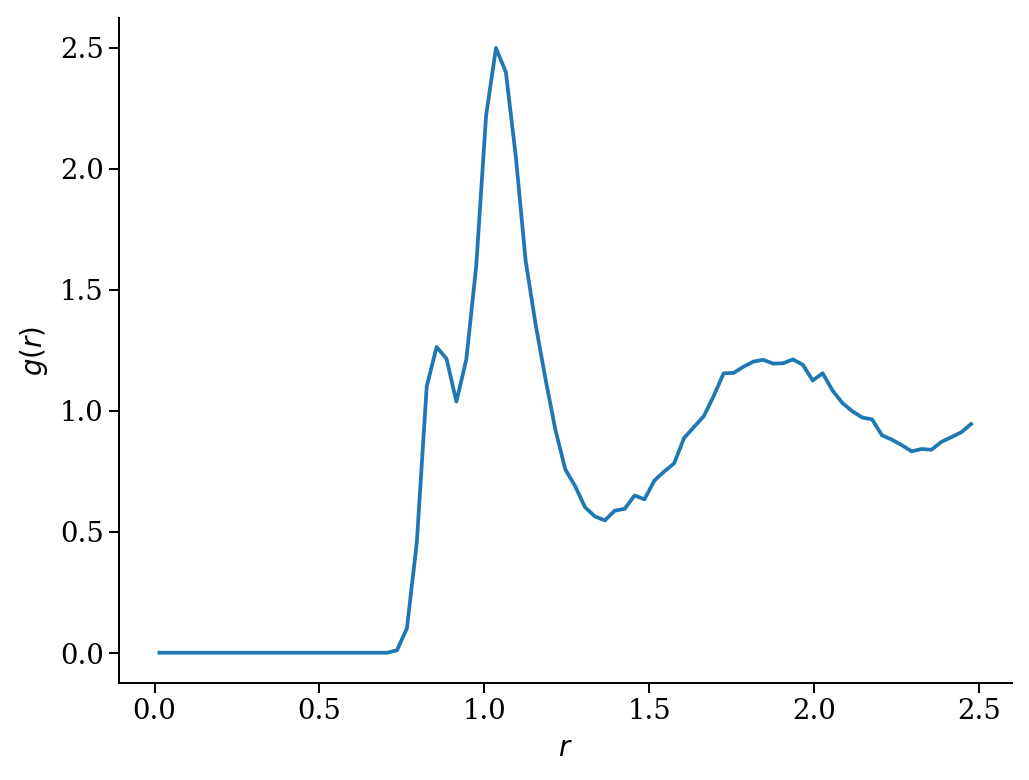

### Mean square displacement

We can also compute dynamical correlation functions. The simplest of
such quantities is the mean squared displacement (MSD). This is defined
as

$$ \delta r^2(t)= \langle |\mathbf{r}(t-t_0) - \mathbf{r}(t_0)|^2\rangle$$

The average is usually performed over all the $N$ particles and over
multiple time origins $t_0$.

The analysis process is now familiar. First we construct the msd object
and then perform the calculation with `compute()`. By
default, the time grid is linear.


In [ ]:
msd = pp.MeanSquareDisplacement(th)
msd.compute()
pl.plot(msd.grid, msd.value, '-o')
pl.xlabel("$t$")
pl.ylabel("MSD");

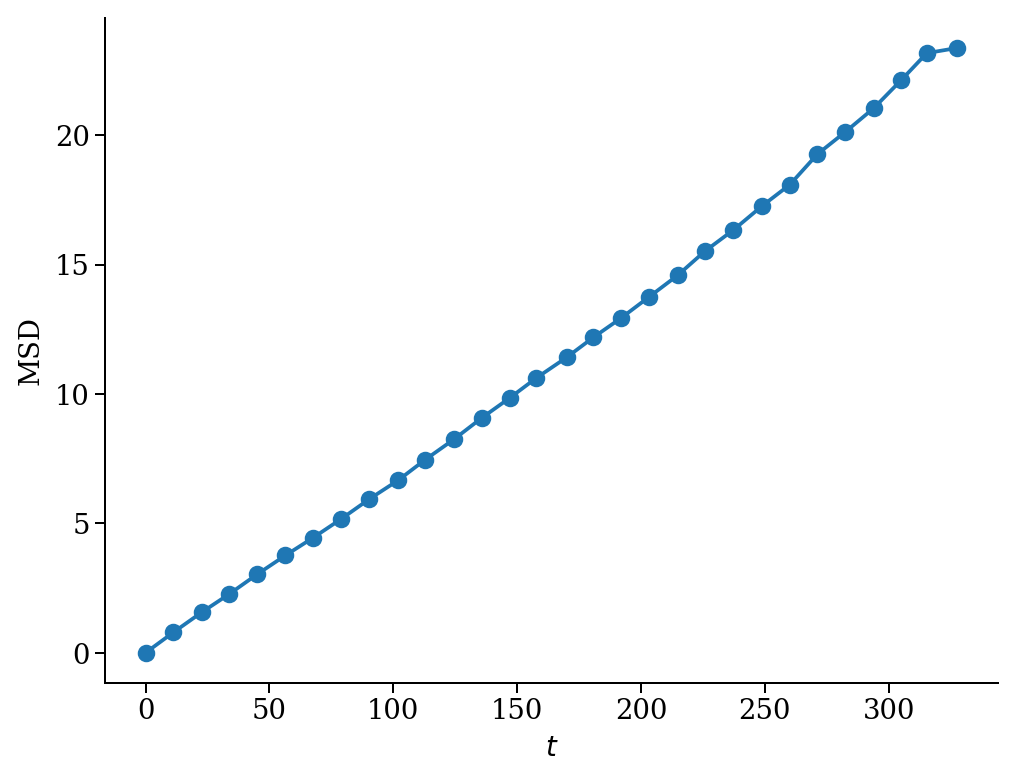

Again, we can compute partial mean square displacements using the
`Partial` class. This time we use an expoentially spaced time
grid. We can clearly distinguish the short time balistic regime from the
diffusion one at long times. The intermediate inflection is a signal of
incipient glassy dynamics.


In [ ]:
import numpy
tgrid = th.timestep * numpy.logspace(0, 5, base=10)
msds = pp.Partial(pp.MeanSquareDisplacement, species=['A','B'], trajectory=th, tgrid=tgrid)
msds.compute()
pl.loglog(msds.partial['A'].grid, msds.partial['A'].value, '-o', label='A')
pl.loglog(msds.partial['B'].grid, msds.partial['B'].value, '-o', label='B')
pl.legend()
pl.xlabel("$t$")
pl.ylabel("MSD")

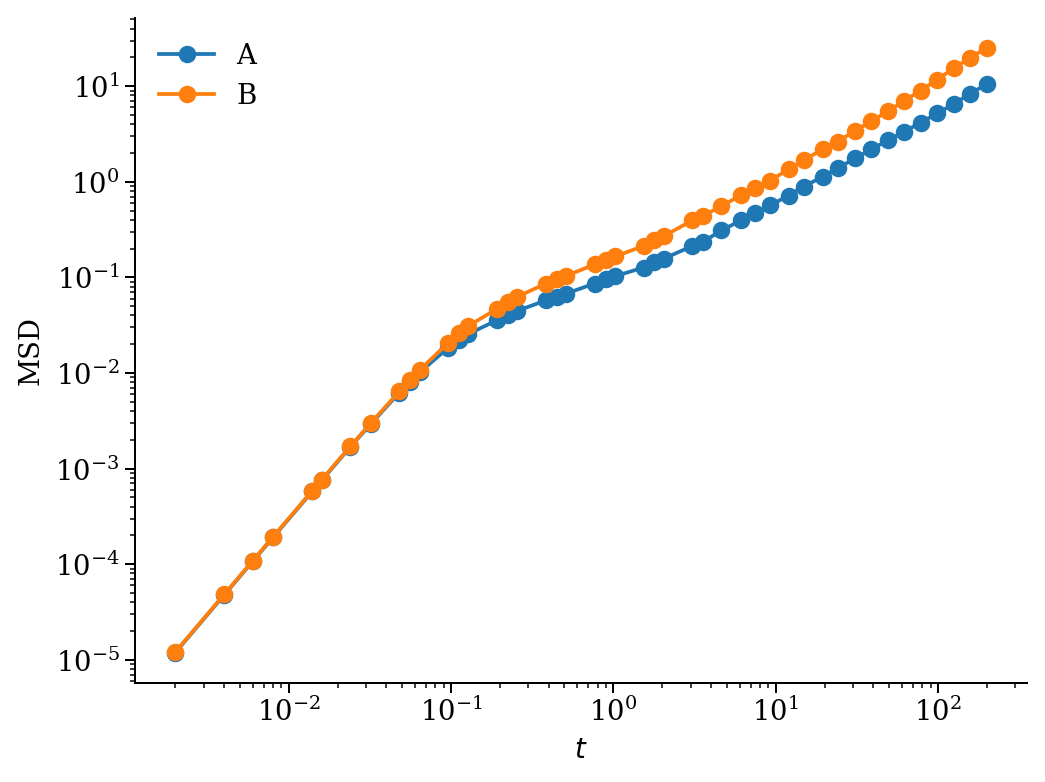

### Self intermediate scattering function

We compute the self part of the intermediate scattering function (ISF)
at specific wave-vectors using a logarithmic time grid. We specify the
norm of the wave-vector we want to use for our calculation
(`kgrid`) and the number of wave-vectors over which the
correlation function will be averaged (`nk`). They are chosen
at random in a shell of width `dk`. To get more info on the
parameters passed to compute the ISF, have a look at the help for the
base class with
`help(pp.fourierspace.FourierSpaceCorrelation)`.


In [ ]:
from math import pi
import numpy
tgrid = th.timestep * numpy.logspace(0, 5, base=10)
isf = pp.Partial(pp.SelfIntermediateScattering, species=["A"], trajectory=th,
                 kgrid=[pi, 7.0], nk=3, dk=0.1, tgrid=tgrid)
isf.compute()

```
Note that now =grid= is a tuple of lists: the first one is the list of all the $k$'s (the $k$ number grid) while the second is the list of $t$'s (the time grid, which is identical for all wave-vectors).
```

The ISF decays to zero at long times, as it should in an ergodic liquid.


In [ ]:
isf_A = isf.partial['A']
pl.semilogx(isf_A.grid[1], isf_A.value[0], '-o', label=f'k={isf_A.grid[0][0]:.2f}') 
pl.semilogx(isf_A.grid[1], isf_A.value[1], '-o', label=f'k={isf_A.grid[0][1]:.2f}') 
pl.legend()
pl.xlabel('$t$')
pl.ylabel('ISF')

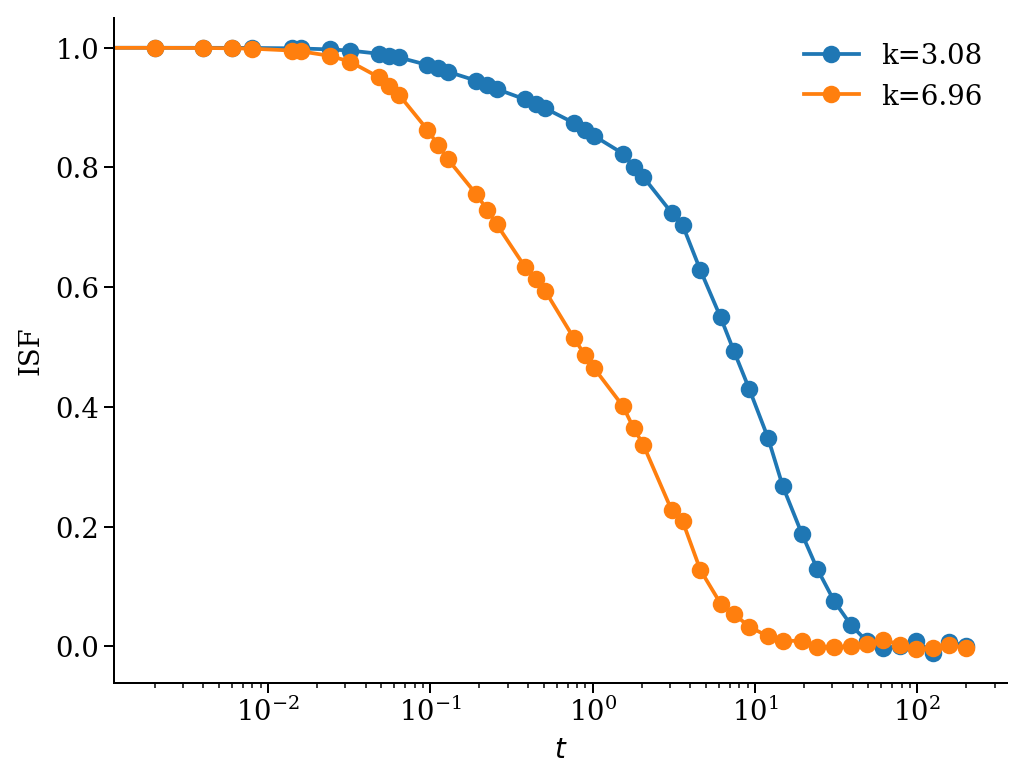

### More correlation functions

Here is the full list of correlation functions currently available in
`postprocessing`, along with the corresponding classes:


In [ ]:
import inspect
import atooms.postprocessing as pp
for cls in inspect.getmembers(pp, inspect.isclass):    
    if issubclass(cls[1], pp.Correlation) \
       and cls[1] is not pp.Correlation \
       and not 'Fast' in cls[0] \
       and not 'Legacy' in cls[0] \
       and not 'Optimized' in cls[0] \
       and not 'Susceptibility' == cls[0]:
        print('- `{}`: {}'.format(cls[0], cls[1].long_name))

```
- `BondAngleDistribution`: bond angle distribution
- `Chi4SelfOverlap`: dynamic susceptibility of self overlap
- `CollectiveOverlap`: collective overlap
- `IntermediateScattering`: intermediate scattering function
- `MeanSquareDisplacement`: mean square displacement
- `NonGaussianParameter`: non-Gaussian parameter
- `RadialDistributionFunction`: radial distribution function
- `S4ktOverlap`: 4-point dynamic structure factor from self overlap
- `SelfIntermediateScattering`: self intermediate scattering function
- `SelfOverlap`: self overlap
- `SpectralDensity`: spectral density
- `StructureFactor`: structure factor
- `VelocityAutocorrelation`: velocity autocorrelation
```

Some of them have multiple implementations (ex. `Fast` and
`Legacy`), which are picked at runtime depending on your
platform. The fastest implementation will be automatically picked up, if
possible.

## Writing your own correlation functions

We can extend the correlation class to compute additional correlation
functions. By default, we get access to particles\' positions and
velocities stored in the following `Correlation` attributes

-   `_pos`: positions as a list of `(ndim, npart)`
    numpy arrays, one per frame
-   `_pos_unf`: same as above but positions are PBC-unfolded
    (useful for dynamic correlations)
-   `_vel`: velocities as a list of
    `(ndim, npart)` numpy arrays, one per frame

### Static correlations

This is a gist of a new correlation class that computes a static
correlation over some grid and averages it over the frames


In [ ]:
import atooms.postprocessing as pp
from collections import defaultdict
import numpy

class NewStaticCorrelation(pp.correlation.Correlation):
    def __init__(self, trajectory, grid):
        # The grid will be stored in self grid
        super().__init__(trajectory, grid)
        # We only need the positions
        self.phasespace = ["pos"]

    def _compute(self):
        # Kernel function
        def my_correlation(grid, pos):
            return numpy.ones_like(grid)

        # We average over all the frames here
        raw = []
        for i in range(len(self._pos)):
            raw.append(my_correlation(self.grid, self._pos[i]))
        self.value = numpy.array(raw).mean(axis=0)

from atooms.trajectory import TrajectoryXYZ
th = TrajectoryXYZ(path)
nw = NewStaticCorrelation(th, [0.0, 1.0])
nw.compute()

### Dynamic correlations

To compute time-dependent correlation function, we can proceed as above,
looping over time origins and computing correlations between frames
spaced by intervals given by an input `grid`. There is a
helper function that deals with finding a suitable set of frames to best
match an input `grid` (assumed to be in real time). This
deals with the general case of trajectories with exponential time
spacing.


In [ ]:
from collections import defaultdict
import atooms.postprocessing as pp
import numpy
from atooms.postprocessing.helpers import setup_t_grid

class NewDynamicCorrelation(pp.correlation.Correlation):
    def __init__(self, trajectory, tgrid):
        pp.correlation.Correlation.__init__(self, trajectory, tgrid)
        self.phasespace = ["pos"]
        # Here we setup a grid of frames that best match the input tgrid
        # See below how to use it
        self._discrete_tgrid = setup_t_grid(self.trajectory, tgrid)

    def _compute(self):
        # Kernel function
        def my_correlation(grid, pos_0, pos_1):
            return 1.0

        assert 0 in self.grid
        raw = defaultdict(list)
        # Here we get an offset frame and a corresponding separation t (in frame)
        for offset, t in self._discrete_tgrid:
            # We loop over compatible origin frames t_0, starting from offset,
            # skipping every self.skip frame
            for t_0 in range(offset, len(self._pos)-t, self.skip):
                # Compute the actual time intervale between the frames in steps
                dt = self.trajectory.steps[t_0 + t] - self.trajectory.steps[t_0]
                cf = my_correlation(self.grid, self._pos[t_0 + t], self._pos[t_0])
                raw[dt].append(cf)

        # Normalization by the value at zero
        self.value = [numpy.mean(raw[dt]) / numpy.mean(raw[0]) for dt in raw]

nw = NewDynamicCorrelation(th, [0.0, 1.0, 2.0])
nw.compute()

## Storing results and analysis

The correlation functions can be written to files, using the
`write()` method.


In [ ]:
msd = pp.MeanSquareDisplacement(th)
msd.compute()
msd.write()

The output file path is interpolated using the variable
`core.pp_output_path`


In [ ]:
print('{} gives {}'.format(pp.core.pp_output_path, msd._output_file))

To change the output file pattern just modify the string. You can use
any `Correlation` attribute enclosed in brackets to
parameterize the output.

The output file is a simple columnar text file containing the grid and
values of the correlation function.

Some correlation functions may implement some basic analysis as well


In [ ]:
msd.analyze()
pprint(msd.analysis)

If `analyze()` is called before `compute()`, the
above dictionary will be written in the output file as well.

Finally, you can perform all the steps above (`compute`,
`analyze`, `write`) in one sweep like this


In [ ]:
msd.do()